In [2]:
!pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.2 MB/s eta 0:00:00


In [5]:
import scipy.stats, emcee
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [6]:
def gendata(N, single=True):
    #generate the data from either one gaussian or mixture of two
    np.random.seed(N)
    x0, s0 = 0, 1
    f0 = 0.9
    x1, s1 = 3, 3
    if single:
        f0 = 1
    flag = (np.random.uniform(size=N)<f0).astype(int)
    res = (flag *   (x0 + s0*np.random.normal(size=N))+
        (1 - flag) * (x1 + s1*np.random.normal(size=N)))
    return res


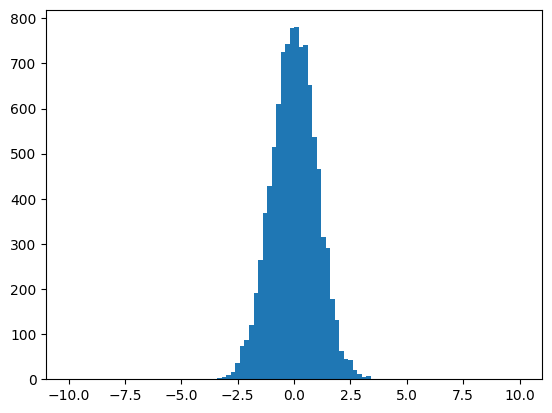

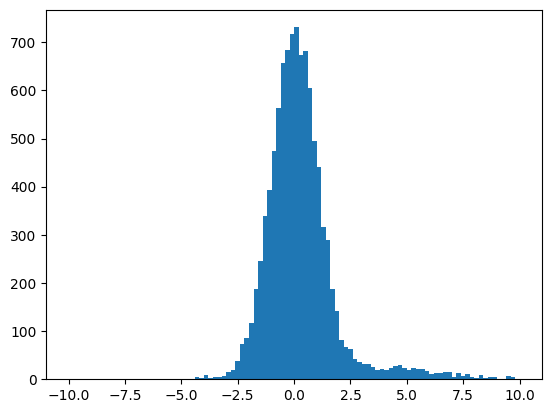

In [7]:
#Simple model with a single Gaussian
tmp = gendata(10000,True)
_=plt.hist(tmp,bins=100,range=[-10,10]);


#The data now was sampled from two Gaussians
tmp = gendata(10000,False)
plt.figure();
_=plt.hist(tmp,bins=100,range=[-10,10])


In [8]:
def like(p,x):
    # Simple log-likelihood with one Gaussian
    c,s = p
    if s<=0:
        return -np.inf
    llike = scipy.stats.norm(c,s).logpdf(x).sum()
    return llike

In [9]:
def run(data):
    # Here we use the Ensemble sampler to fit the data and return the samples of our parameters
    p0 = [1,2]
    ndim = 2
    nwalkers = 4
    nsamp= 2000
    ball = np.random.multivariate_normal(p0, np.diag([0.1,0.1]),nwalkers)
    es = emcee.EnsembleSampler(nwalkers, ndim, like, args=(data,))
    pos,lnp, state =es.run_mcmc(ball,nsamp)
    es.reset()
    es.run_mcmc(pos,nsamp)

    chain=es.flatchain
    return chain


In [10]:
ndat=10000
dat_single = gendata(ndat,True)
chain_single = run(dat_single)
dat  = gendata(ndat,False)
chain = run(dat)

In [11]:
def gen_ppc(chain, ndat, nrepl, seed=1):
    # Generate Replicated data
    np.random.seed(seed)
    n= chain.shape[0]
    nperchain = 10 # generate 10 data points per chain
    simdat= []
    for i in range(nrepl):
        curi=np.random.randint(n)
        N = scipy.stats.norm(chain[curi,0], chain[curi,1])
        # pick up random sample from the chain

        # Use it to genereate a "replicated dataset"
        simdat.append(N.rvs(ndat))

    return simdat

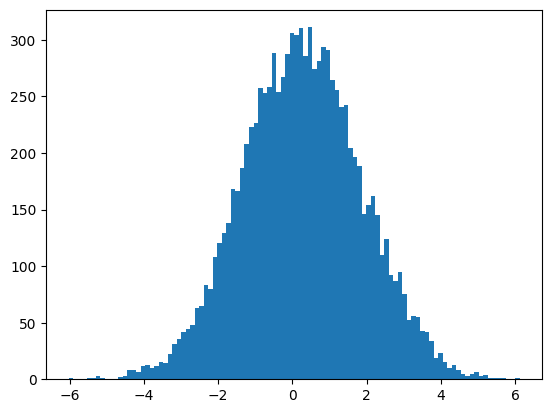

In [12]:
nrepl = 500
repldat = gen_ppc(chain, ndat, nrepl)
# One replicated dataset
_ = plt.hist(repldat[1], bins=100)


In [13]:
def checks(dat, chain, nrepl=1000, check='mean'):
    # Do a predictive posterior check
    ndat = len(dat)

    ppc = gen_ppc(chain, ndat, nrepl)
    ## ppc is our set of replicated dasets

    # Many possible statistics
    if check=='perc95':
        func = lambda x : scipy.stats.scoreatpercentile(x,95)
    if check=='perc5':
        func = lambda x : scipy.stats.scoreatpercentile(x,5)
    if check=='std':
        func = lambda x : np.std(x)
    if check=='mean':
        func = lambda x : np.mean(x)
    if check=='max':
        func = lambda x : np.max(x)

    stats= []
    for cursim in ppc:
        #for each replicated dataset we compute our test statsitic
        stat = func(cursim)
        stats.append(stat)
    plt.clf()
    plt.hist(stats,bins=30,color='grey')
    ts_actual = func(dat) #  the actual value of the test statistic in our data
    plt.plot([ts_actual]*2,[-1,plt.gca().get_ylim()[1]])


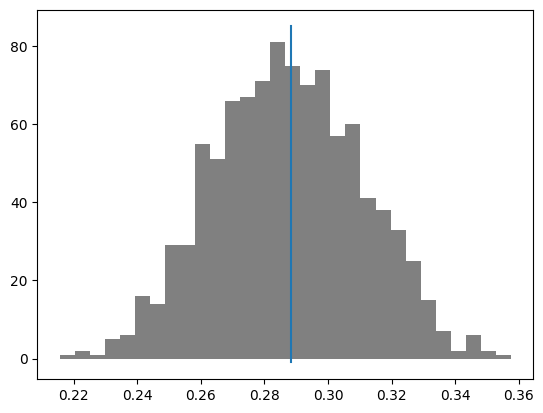

In [14]:
checks(dat, chain,check='mean')

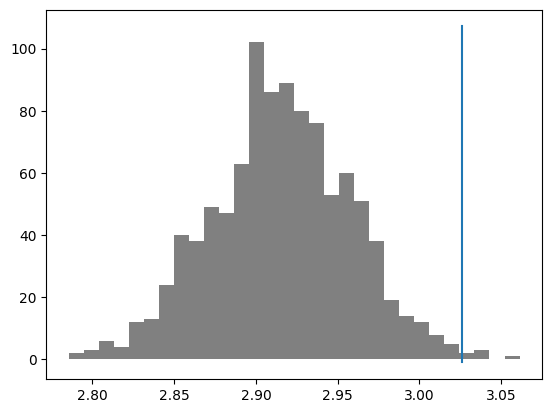

In [15]:
checks(dat, chain,check='perc95')

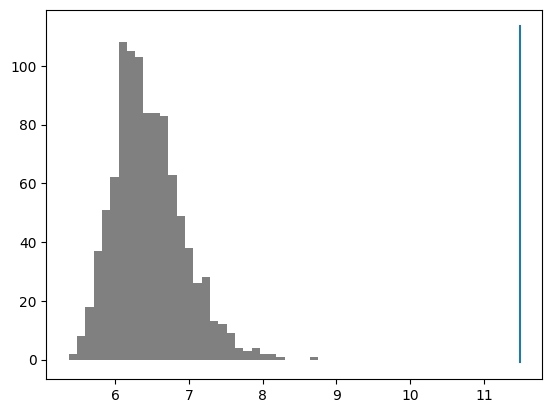

In [16]:
checks(dat, chain,check='max')
#We see when we compute the maximum value in our dataset the replicated datasets do not
# come even close to the observed dataset
# That should be the reason to revisit the model